In [1]:
#+.+
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import glob
from pathlib import Path
import torch


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739,

In [2]:
root=Path("data/animals")
records=[]

for cls in root.iterdir(): 
    if cls.is_dir(): 
        imgs=list(cls.glob("*"))
        for img_path in imgs: 
            try: 
                with Image.open(img_path) as img: 
                    w,h=img.size
                records.append({
                    "class":cls.name,
                    "width":w,
                    "height":h,
                    "filepath":str(img_path)
                })
            except Exception: 
                pass

df=pd.DataFrame(records)

In [3]:
print(f"Total images: {len(df)}")
print(f"Total classes of animals: {df['class'].nunique()}")
print(f"Size of classes: {df['class'].value_counts()}")
print(f"All classes have 60 images?: {(df['class'].value_counts()).nunique()==1}")

Total images: 5400
Total classes of animals: 90
Size of classes: class
hippopotamus    60
oyster          60
kangaroo        60
parrot          60
chimpanzee      60
                ..
penguin         60
bear            60
hare            60
goldfish        60
possum          60
Name: count, Length: 90, dtype: int64
All classes have 60 images?: True


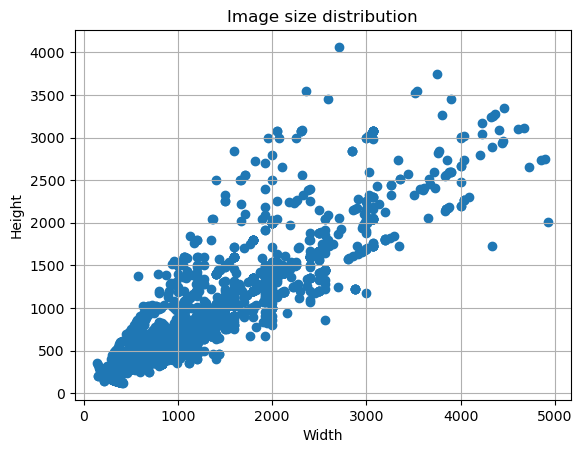

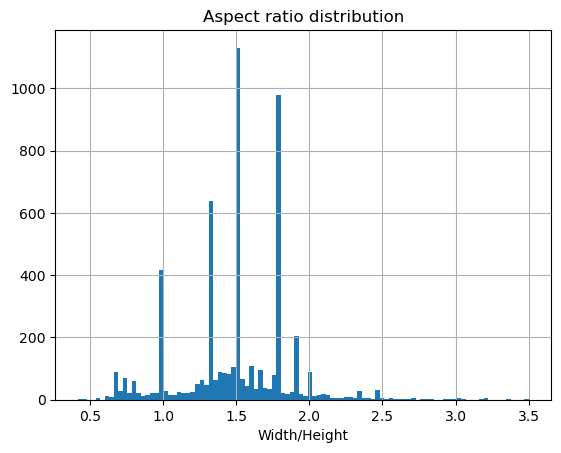

In [4]:
plt.scatter(df["width"],df["height"])
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image size distribution")
plt.grid()
plt.show()

aspect_ratio=df['width']/df['height']
aspect_ratio.hist(bins=100)
plt.xlabel("Width/Height")
plt.title("Aspect ratio distribution")
plt.show()

In [8]:
sample_paths=df['filepath'].sample(n=1000,random_state=42)
rgb_sums=[0.0,0.0,0.0]
rgb_sqsums=[0.0,0.0,0.0]
total_pixels=0

for path in sample_paths: 
    img=Image.open(path).convert("RGB")
    pixels=list(img.getdata())
    for r,g,b in pixels: 
        rgb_sums[0]+=r/255 #normalize: 0-255 -> 0-1 
        rgb_sums[1]+=g/255
        rgb_sums[2]+=b/255
        rgb_sqsums[0]+=(r/255)**2
        rgb_sqsums[1]+=(g/255)**2
        rgb_sqsums[2]+=(b/255)**2
    total_pixels+=len(pixels)

mean=[s/total_pixels for s in rgb_sums]
std=[np.sqrt(sq/total_pixels-m**2) for sq,m in zip(rgb_sqsums,mean)]
print("RGB mean across all pixels: ", mean, "\nRGB std across all pixels: ", std)

RGB mean across all pixels:  [0.539095009313355, 0.5253846275760173, 0.47516918293895094] 
RGB std across all pixels:  [np.float64(0.29325260016825044), np.float64(0.2845220684942233), np.float64(0.30522874839608877)]


In [11]:
mean_w=df['width'].mean()
mean_h=df['height'].mean()
print("WidthxHeight mean across all images: ",mean_w,'x',mean_h)
print("Aspect ratio on avg: ", mean_w/mean_h)

WidthxHeight mean across all images:  808.5903703703704 x 566.8392592592593
Aspect ratio on avg:  1.4264897096701266


Now we know what to normalize around. We will opt for **280 x 196**--both numbers are divisible by 4, and most importantly the aspect ratio is very close to the average here which will preserve the geometry of our images and not distort them. 